# Now we start Deep Reinforcement Learning!

Code: Provided by Sunmook Choi (email: felixchoi@korea.ac.kr)

A code of **DQN algorithm** is given in this notebook to solve a given problem.




## Requirements

In [128]:
!pip install gymnasium
!pip install pygame

DEPRECATION: Loading egg at /Users/yun-seungcho/anaconda3/lib/python3.11/site-packages/labelImg-1.8.6-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/yun-seungcho/anaconda3/lib/python3.11/site-packages/labelImg-1.8.6-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [129]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

import PIL.Image
from IPython.display import Image

## Cart Pole Environment

Since we are dealing with ``DQN``, we choose an environment with **continuous** state space and **discrete** action space.
- https://gymnasium.farama.org/environments/classic_control/cart_pole/
- state space: 4-dim array
    - cart position [-4.8, 4.8]
    - cart velocity (-inf, inf)
    - pole angle [-24°, 24°] or (-0.418 rad, +0.418 rad)
    - pole angualr velocity (-inf, inf)
- action space
    - 0: push cart to the left
    - 1: push cart to the right
    - Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.
- reward function
    - Goal: keep the pole upright for as long as possible
    - +1 for every step taken, including the termination step.
- starting state
    - all observations are assigned a uniformly random value in (-0.05, 0.05).
- Episode End
    1. Termination: Pole Angle is greater than ±12°.
    2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Truncation: Episode length is greater than 500.


In [130]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
observation, info = env.reset(seed=830)
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [131]:
observation

array([-0.01631934, -0.04071044,  0.0260449 , -0.02031027], dtype=float32)

In [132]:
info

{}

In [133]:
print(env.observation_space.shape)
print(env.action_space.n)

(4,)
2


## Deep Q-Network Preliminaries

[DQN algorithm](https://youtu.be/C-mfKSM0VFQ?si=3aZzPrgefo33zSIs&t=1004)

1. We need DQN agent which is a neural network that approximates the Q-table function. It takes a state as input and outputs the Q-values for all actions with respect to the given state.

2. We need a replay buffer that saves recent transition tuples. We also randomly choose samples from the buffer to alleviate temporal correlation.

3. We also need a target network which is designed to resolve non-stationary target problem.

DQN is based on Q-learning.
$$ L(\theta) = \frac{1}{B} \sum_{i\in B} \Big[ r_{i+1} + \gamma \max_a \hat{Q}(s_{i+1}, a; \hat{\theta}) - Q(s_i,a_i;\theta) \Big]^2$$

## Replay Buffer

In [134]:
## Double-Ended Queue

from collections import deque

In [135]:
class ReplayBuffer():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])

    def replay_buffer_sampling(self, batch_size):
        experience_samples = random.sample(self.buffer, batch_size)
        state_arr, action_arr, reward_arr, next_state_arr, done_arr = map(np.asarray, zip(*experience_samples))
        return state_arr, action_arr, reward_arr, next_state_arr, done_arr

    def size(self):
        return len(self.buffer)

## Q-Networks
- How to define and update networks

In [136]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

In [137]:
# Define a Q-Network.
def nn_model(input_size, action_dim):
    input_layer = Input(shape=input_size)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(input_layer)
    x = Dense(48, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(16, activation='relu', kernel_initializer='he_uniform')(x)
    output_layer = Dense(action_dim, activation='linear')(x)

    model = Model(input_layer, outputs = output_layer)
    return model

# Target Network update
def update_target(behavior, target):
    target.set_weights(behavior.get_weights())

def soft_update_target(behavior, target, TAU):
    for t, e in zip(target.trainable_variables, behavior.trainable_variables):
        t.assign(t * (1 - TAU) + e * TAU)

In [138]:
behavior_network = nn_model(env.observation_space.shape, env.action_space.n)
target_network = nn_model(env.observation_space.shape, env.action_space.n)

In [139]:
behavior_network.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_184 (Dense)           (None, 128)               640       
                                                                 
 dense_185 (Dense)           (None, 48)                6192      
                                                                 
 dense_186 (Dense)           (None, 16)                784       
                                                                 
 dense_187 (Dense)           (None, 2)                 34        
                                                                 
Total params: 7650 (29.88 KB)
Trainable params: 7650 (29.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
def update_Q(behavior_net, target_net, optimizer, buffer, batch_size, gamma):

    with tf.GradientTape() as tape:
        state_arr, action_arr, reward_arr, next_state_arr, done_arr = buffer.replay_buffer_sampling(batch_size)
        predicts = tf.reduce_sum(behavior_net(state_arr, training=True)*action_arr, axis=1)
        next_q_values = tf.math.reduce_max(target_net(next_state_arr, training=False), axis=1)
        targets = reward_arr + gamma*next_q_values*(1-done_arr)
        td = targets - predicts
        loss = tf.reduce_mean(td**2)

    grads = tape.gradient(loss, behavior_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, behavior_net.trainable_variables))

## Epsilon-Greedy action choice


In [141]:
def linear_schedule(episode, max_episode, initial, final):
    start, end = initial, final
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [142]:
def get_action(behavior_net, state, epsilon):
    action_logits = behavior_net.predict_on_batch(state.reshape(1,-1))    # input shape should be (batch, state_dim)
    num_actions = action_logits.shape[1]

    should_explore = np.random.rand()
    if should_explore < epsilon:
        action = np.random.choice(num_actions)
    else:
        action = np.argmax(action_logits, axis=1)[0]
    return action

## Train DQN Agent

In [144]:
def train(env, max_episode, buffer_size, initial_epsilon, final_epsilon, initial_lr, final_lr, gamma, replay_period=(1,100), batch_size=64, plot_period=100):

    reward_list = []
    action_num = env.action_space.n
    one_hot_action = np.eye(action_num)

    replay_buffer = ReplayBuffer(capacity=buffer_size)

    behavior_Q = nn_model(env.observation_space.shape, env.action_space.n)
    target_Q = nn_model(env.observation_space.shape, env.action_space.n)

    update_target(behavior_Q, target_Q)
    optimizer = tf.keras.optimizers.legacy.Adam()

    for episode in range(max_episode):

        terminated = False
        truncated = False
        done = terminated or truncated

        episode_reward = 0
        episode_length = 0

        epsilon = linear_schedule(episode, max_episode//2, initial_epsilon, final_epsilon)
        lr      = linear_schedule(episode, max_episode, initial_lr, final_lr)
        optimizer.learning_rate = lr

        state, _ = env.reset()

        while not done:
            action = get_action(behavior_Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_length += 1

            replay_buffer.store(state, one_hot_action[action], reward, next_state, done)

            if replay_buffer.size() >= batch_size and episode_length%replay_period[0] == 0:
                update_Q(behavior_Q, target_Q, optimizer, replay_buffer, batch_size, gamma)

            if replay_buffer.size() >= batch_size and episode_length%replay_period[1] == 0:
                update_target(behavior_Q, target_Q)
                # soft_update_target(behavior_Q, target_Q, TAU=0.005)

            state = next_state

        reward_list.append(episode_reward)

        if episode % plot_period == plot_period-1:
            print(f'Episode: {episode+1:4d}, total reward: {episode_reward}, buffer size: {replay_buffer.size():5d}, epsilon: {epsilon:.4f}, learning_rate: {lr:.4f}')

    x_axis = np.arange(1, max_episode+1)
    plt.figure(figsize=[3,3], dpi=300)
    plt.title('DQN', fontsize=9)
    plt.plot(x_axis, reward_list, 'b-', linewidth=.5)
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel('Total Rewards', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)
    plt.show()

    return behavior_Q, replay_buffer, reward_list

Episode:   20, total reward: 68.0, buffer size:   488, epsilon: 0.9658, learning_rate: 0.0098
Episode:   40, total reward: 21.0, buffer size:   966, epsilon: 0.9298, learning_rate: 0.0096
Episode:   60, total reward: 19.0, buffer size:  1475, epsilon: 0.8938, learning_rate: 0.0094
Episode:   80, total reward: 26.0, buffer size:  1996, epsilon: 0.8578, learning_rate: 0.0092
Episode:  100, total reward: 49.0, buffer size:  2584, epsilon: 0.8218, learning_rate: 0.0090
Episode:  120, total reward: 19.0, buffer size:  3206, epsilon: 0.7858, learning_rate: 0.0088
Episode:  140, total reward: 52.0, buffer size:  3945, epsilon: 0.7498, learning_rate: 0.0086
Episode:  160, total reward: 46.0, buffer size:  4600, epsilon: 0.7138, learning_rate: 0.0084
Episode:  180, total reward: 25.0, buffer size:  5666, epsilon: 0.6778, learning_rate: 0.0082
Episode:  200, total reward: 11.0, buffer size:  6413, epsilon: 0.6418, learning_rate: 0.0080
Episode:  220, total reward: 14.0, buffer size:  7654, epsil

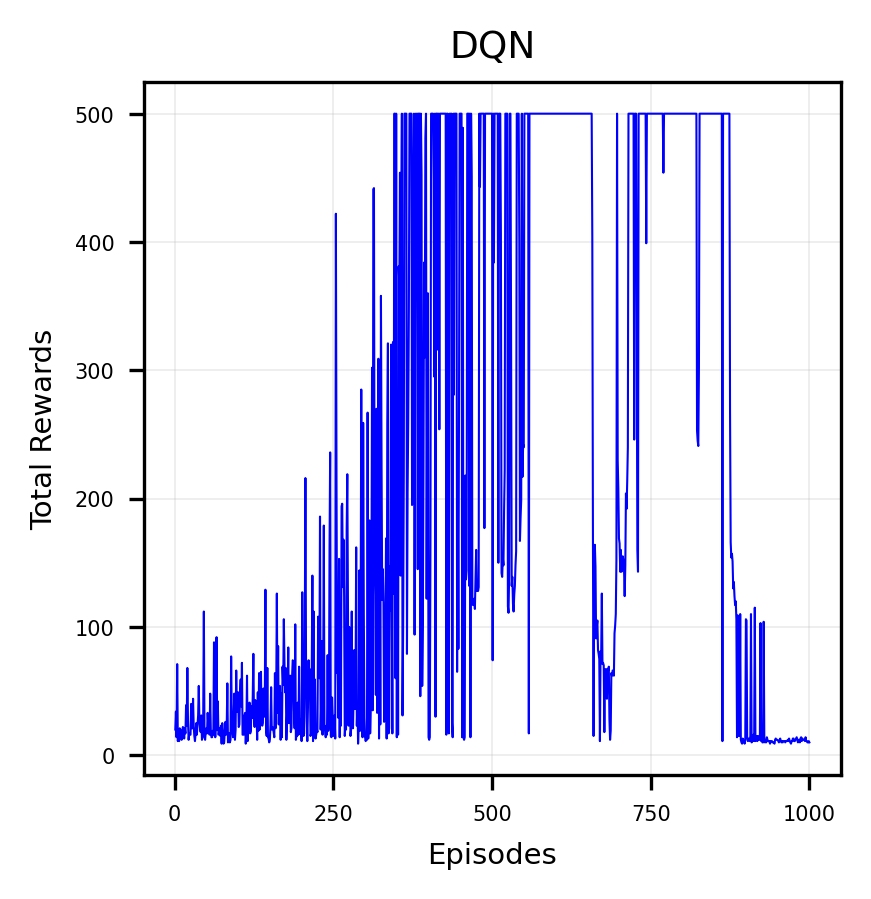

In [116]:
Q_network, replay_buffer, reward_list = train(env, max_episode=1000, buffer_size=60000, initial_epsilon=1.0, final_epsilon=0.05, initial_lr=0.01, final_lr=0.0001, gamma=1.0, replay_period=(1,20), batch_size=64, plot_period=20)

## Test the agent

In [123]:
def play_and_save(Q_network, name='', seed=None):
    render_images = []

    state, _ = env.reset(seed=seed)
    image_array = env.render()
    render_images.append(PIL.Image.fromarray(image_array))

    terminated, truncated = False, False

    while not terminated and not truncated:
        action = np.argmax(Q_network.predict_on_batch(state.reshape(1,-1)), axis=1)[0]
        state, reward, terminated, truncated, _ = env.step(action)
        image_array = env.render()
        render_images.append(PIL.Image.fromarray(image_array))

    filename = 'play_'+name+'.gif'

    render_images[0].save(filename, save_all=True, optimize=False, append_images=render_images[1:], duration=5, loop=0)
    print('GIF is made successfully!')
    print(len(render_images))
    return filename



In [23]:
saved_fname = play_and_save(Q_network, '1', seed=8)

GIF is made successfully!


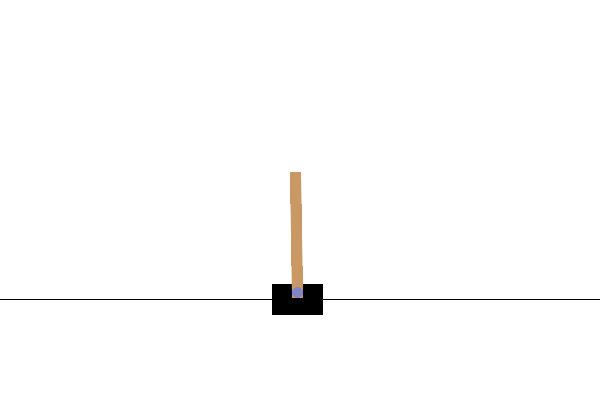

In [24]:
Image(open(saved_fname,'rb').read())

GIF is made successfully!


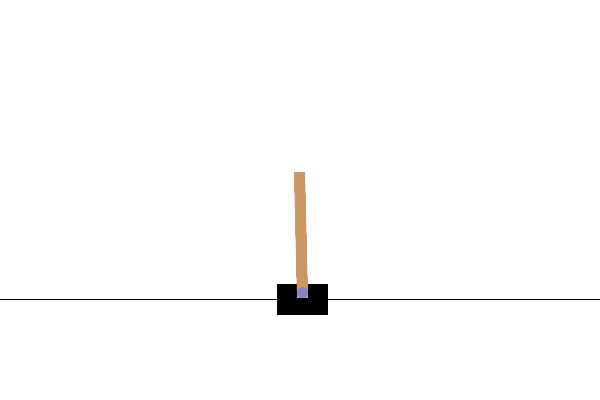

In [25]:
saved_fname2 = play_and_save(Q_network, '2', seed=2024)
Image(open(saved_fname2,'rb').read())

## Homework

Episode:   20, total reward: 15.0, buffer size:   402, epsilon: 0.9639, learning_rate: 0.0098
Episode:   40, total reward: 20.0, buffer size:   802, epsilon: 0.9259, learning_rate: 0.0096
Episode:   60, total reward: 24.0, buffer size:  1360, epsilon: 0.8879, learning_rate: 0.0094
Episode:   80, total reward: 16.0, buffer size:  1850, epsilon: 0.8499, learning_rate: 0.0092
Episode:  100, total reward: 56.0, buffer size:  2386, epsilon: 0.8119, learning_rate: 0.0090
Episode:  120, total reward: 14.0, buffer size:  3039, epsilon: 0.7739, learning_rate: 0.0088
Episode:  140, total reward: 42.0, buffer size:  3661, epsilon: 0.7359, learning_rate: 0.0086
Episode:  160, total reward: 15.0, buffer size:  4115, epsilon: 0.6979, learning_rate: 0.0084
Episode:  180, total reward: 12.0, buffer size:  4710, epsilon: 0.6599, learning_rate: 0.0082
Episode:  200, total reward: 16.0, buffer size:  5389, epsilon: 0.6219, learning_rate: 0.0080
Episode:  220, total reward: 112.0, buffer size:  6069, epsi

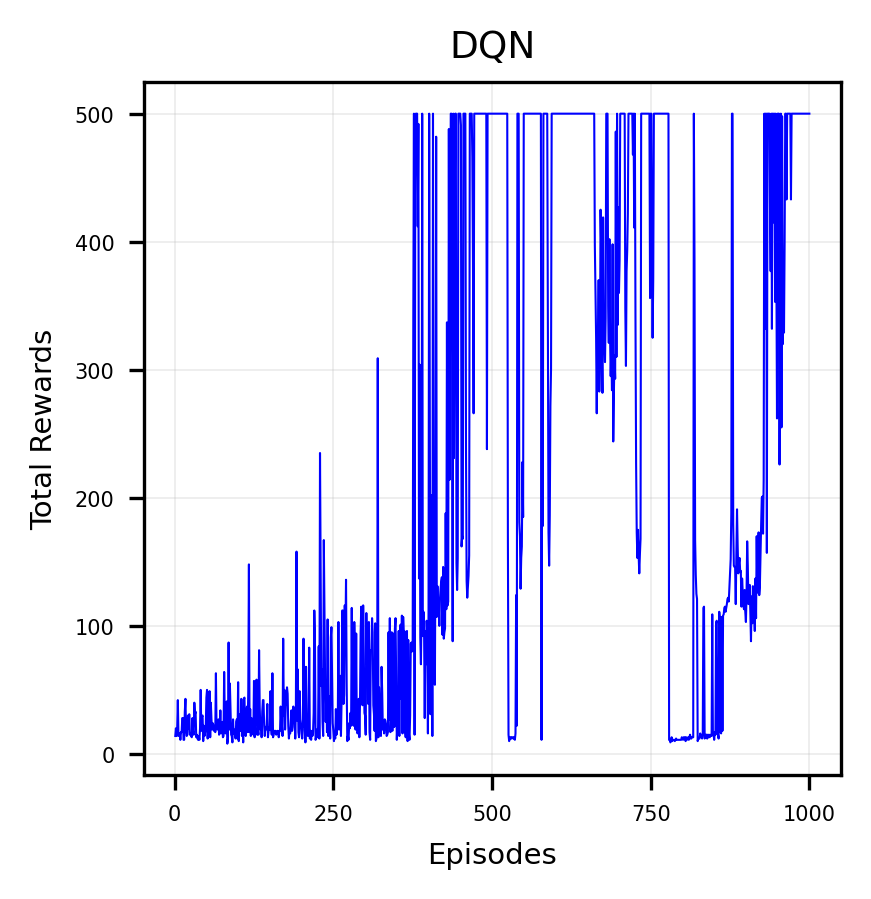

In [145]:
Q_network2, replay_buffer2, reward_list2 = train(env, max_episode=1000, buffer_size=30000, initial_epsilon=1.0, final_epsilon=0.05, initial_lr=0.01, final_lr=0.0001, gamma=1.0, replay_period=(1,20), batch_size=128, plot_period=20)

GIF is made successfully!
501


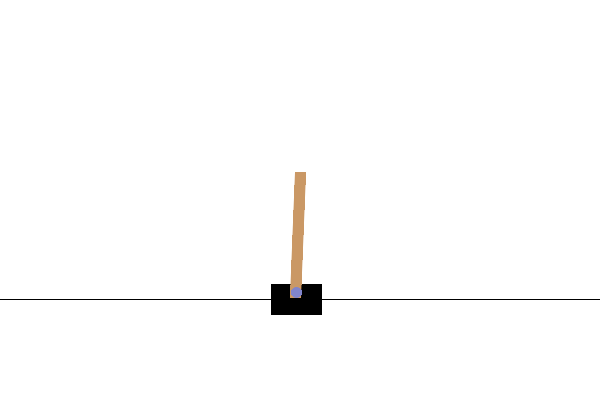

In [146]:
saved_fname = play_and_save(Q_network2, '1', seed=1312)
Image(open(saved_fname,'rb').read())


1. [Discussion] The plot seems awkward. What is happening now? Bring your thoughts and let's have a talk.
    - Bring your opinion about why such a plot is made.
    - You are encouraged to bring supporting evidence for your opinion.
2. [Code] Improve the result.
    - 'Better' solution may vary depending on what you are aiming for. Define your own meaning of what a 'better' solution is.
    - Any DQN variants are allowed (Double DQN, Dueling DQN etc.), except for `Prioritized Experience Replay`. We will talk about it in the next session.
3. [Discussion] If we render the game and obtain images...
    - In DQN, we learned that 4 consecutive images are taken as input to Q-network.
    - During the four steps, what should an agent do? That is, what action should an agent take?
    - You can try to make such a code.
4. [Extra Question] If you want to try, make a DQN algorithm code whose agent takes rendered images as input. For this question, you may change the environment.

Episode:   20, total reward: 39.0, buffer size:   498, epsilon: 0.9696, learning_rate: 0.0098
Episode:   40, total reward: 31.0, buffer size:  1155, epsilon: 0.9376, learning_rate: 0.0096
Episode:   60, total reward: 13.0, buffer size:  1551, epsilon: 0.9056, learning_rate: 0.0094
Episode:   80, total reward: 14.0, buffer size:  2093, epsilon: 0.8736, learning_rate: 0.0092
Episode:  100, total reward: 19.0, buffer size:  2510, epsilon: 0.8416, learning_rate: 0.0090
Episode:  120, total reward: 12.0, buffer size:  3000, epsilon: 0.8096, learning_rate: 0.0088
Episode:  140, total reward: 16.0, buffer size:  3659, epsilon: 0.7776, learning_rate: 0.0086
Episode:  160, total reward: 48.0, buffer size:  4232, epsilon: 0.7456, learning_rate: 0.0084
Episode:  180, total reward: 13.0, buffer size:  4642, epsilon: 0.7136, learning_rate: 0.0082
Episode:  200, total reward: 16.0, buffer size:  5142, epsilon: 0.6816, learning_rate: 0.0080
Episode:  220, total reward: 35.0, buffer size:  5926, epsil

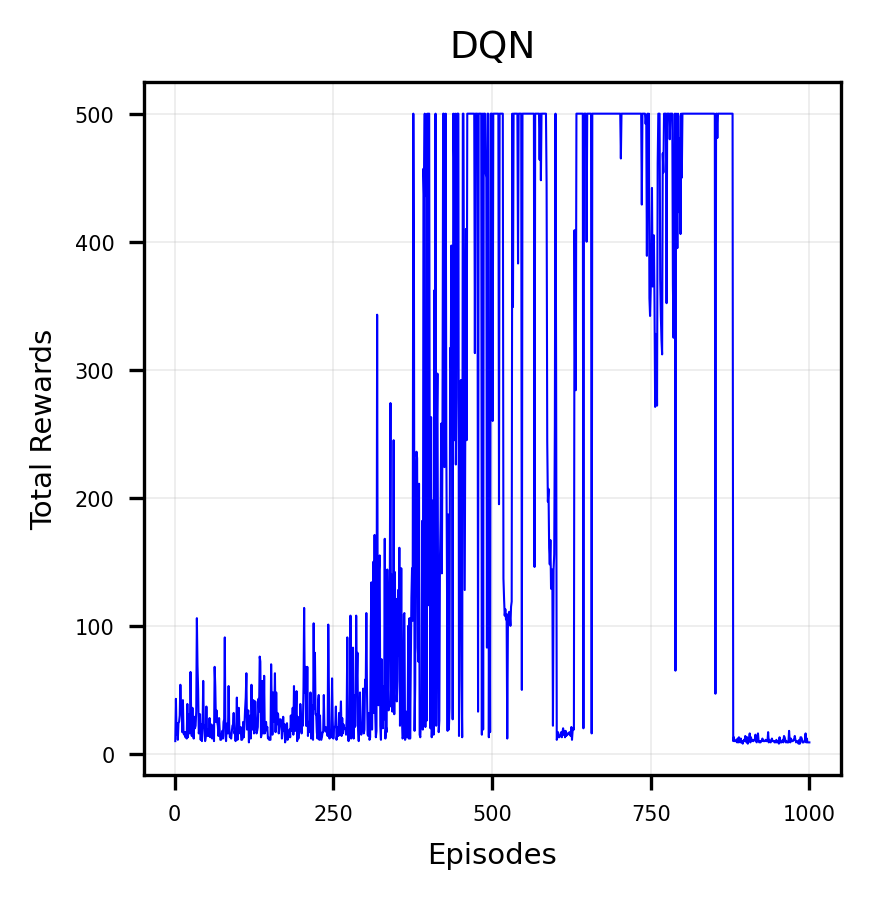

In [26]:
Q_network2, replay_buffer2, reward_list2 = train(env, max_episode=1000, buffer_size=30000, initial_epsilon=1.0, final_epsilon=0.2, initial_lr=0.01, final_lr=0.0001, gamma=1.0, replay_period=(1,20), batch_size=64, plot_period=20)

GIF is made successfully!


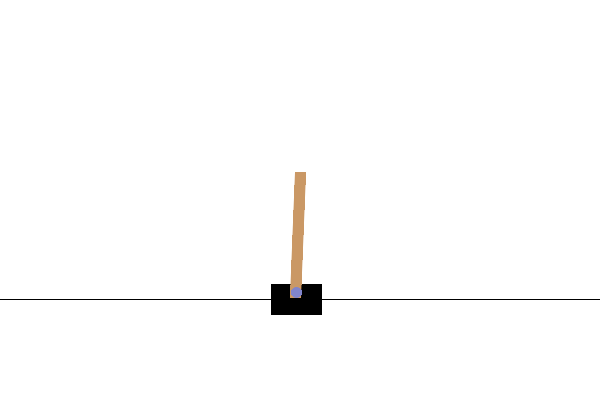

In [119]:
saved_fname = play_and_save(Q_network2, '1', seed=1312)
Image(open(saved_fname,'rb').read())

In [99]:
def update_DoubleQ(behavior_net, target_net, optimizer, buffer, batch_size, gamma):
    with tf.GradientTape() as tape:
        state_arr, action_arr, reward_arr, next_state_arr, done_arr = buffer.replay_buffer_sampling(batch_size)
        #print(next_state_arr.shape) # (64,4)
        predicts = tf.reduce_sum(behavior_net(state_arr, training=True) * action_arr, axis=1)
        best_actions = tf.argmax(behavior_net(next_state_arr, training=False), axis=1) # Behavior network에서 Q값이 최대인 action을 선택
        #print(best_actions) # (64,)
        batch_indices = tf.range(batch_size, dtype=tf.int64)
        indices = tf.stack((batch_indices, best_actions), axis=1)
        next_q_values = tf.gather_nd(target_net(next_state_arr, training=False), indices)
        targets = reward_arr + gamma * next_q_values * (1 - done_arr)
        loss = tf.reduce_mean((targets - predicts) ** 2)

    grads = tape.gradient(loss, behavior_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, behavior_net.trainable_variables))

In [100]:
def train_double(env, max_episode, buffer_size, initial_epsilon, final_epsilon, initial_lr, final_lr, gamma, replay_period=(1,100), batch_size=64, plot_period=100):

    reward_list = []
    action_num = env.action_space.n
    one_hot_action = np.eye(action_num)

    replay_buffer = ReplayBuffer(capacity=buffer_size)

    behavior_Q = nn_model(env.observation_space.shape, env.action_space.n)
    target_Q = nn_model(env.observation_space.shape, env.action_space.n)

    update_target(behavior_Q, target_Q)
    optimizer = tf.keras.optimizers.legacy.Adam()

    for episode in range(max_episode):

        terminated = False
        truncated = False
        done = terminated or truncated

        episode_reward = 0
        episode_length = 0

        epsilon = linear_schedule(episode, max_episode//2, initial_epsilon, final_epsilon)
        lr      = linear_schedule(episode, max_episode, initial_lr, final_lr)
        optimizer.learning_rate = lr

        state, _ = env.reset()

        while not done:
            action = get_action(behavior_Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_length += 1

            replay_buffer.store(state, one_hot_action[action], reward, next_state, done)

            if replay_buffer.size() >= batch_size and episode_length%replay_period[0] == 0:
                update_DoubleQ(behavior_Q, target_Q, optimizer, replay_buffer, batch_size, gamma)

            if replay_buffer.size() >= batch_size and episode_length%replay_period[1] == 0:
                update_target(behavior_Q, target_Q)
                # soft_update_target(behavior_Q, target_Q, TAU=0.005)

            state = next_state

        reward_list.append(episode_reward)

        if episode % plot_period == plot_period-1:
            print(f'Episode: {episode+1:4d}, total reward: {episode_reward}, buffer size: {replay_buffer.size():5d}, epsilon: {epsilon:.4f}, learning_rate: {lr:.4f}')

    x_axis = np.arange(1, max_episode+1)
    plt.figure(figsize=[3,3], dpi=300)
    plt.title('Double DQN', fontsize=9)
    plt.plot(x_axis, reward_list, 'b-', linewidth=.5)
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel('Total Rewards', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)
    plt.show()

    return behavior_Q, replay_buffer, reward_list

Episode:   20, total reward: 16.0, buffer size:   501, epsilon: 0.9639, learning_rate: 0.0098
Episode:   40, total reward: 36.0, buffer size:   935, epsilon: 0.9259, learning_rate: 0.0096
Episode:   60, total reward: 11.0, buffer size:  1358, epsilon: 0.8879, learning_rate: 0.0094
Episode:   80, total reward: 25.0, buffer size:  1974, epsilon: 0.8499, learning_rate: 0.0092
Episode:  100, total reward: 15.0, buffer size:  2456, epsilon: 0.8119, learning_rate: 0.0090
Episode:  120, total reward: 56.0, buffer size:  3003, epsilon: 0.7739, learning_rate: 0.0088
Episode:  140, total reward: 9.0, buffer size:  3629, epsilon: 0.7359, learning_rate: 0.0086
Episode:  160, total reward: 28.0, buffer size:  4334, epsilon: 0.6979, learning_rate: 0.0084
Episode:  180, total reward: 13.0, buffer size:  4800, epsilon: 0.6599, learning_rate: 0.0082
Episode:  200, total reward: 16.0, buffer size:  5392, epsilon: 0.6219, learning_rate: 0.0080
Episode:  220, total reward: 21.0, buffer size:  5869, epsilo

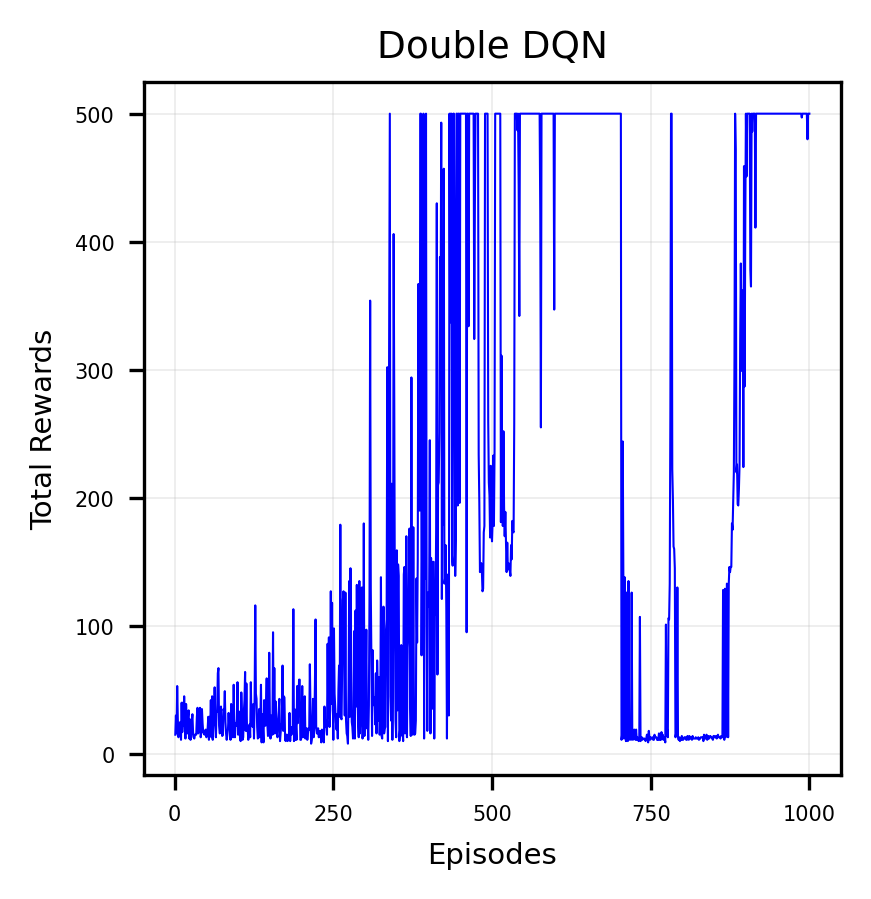

In [101]:
Q_network_double, replay_buffer_double, reward_list_double = train_double(env, max_episode=1000, buffer_size=60000, initial_epsilon=1.0, final_epsilon=0.05, initial_lr=0.01, final_lr=0.0001, gamma=1.0, replay_period=(1,20), batch_size=64, plot_period=20)

GIF is made successfully!
501


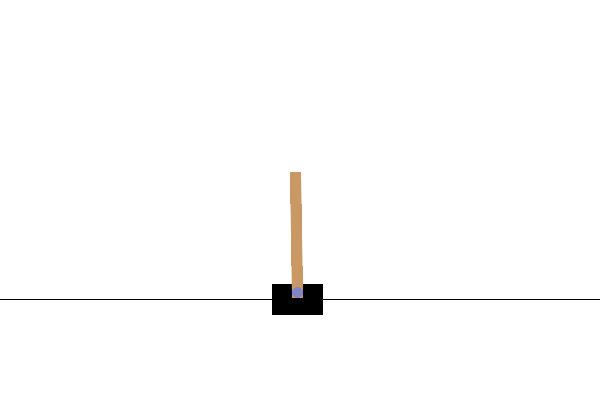

In [124]:
saved_fname = play_and_save(Q_network_double, '1', seed=8)
Image(open(saved_fname,'rb').read())

GIF is made successfully!
501


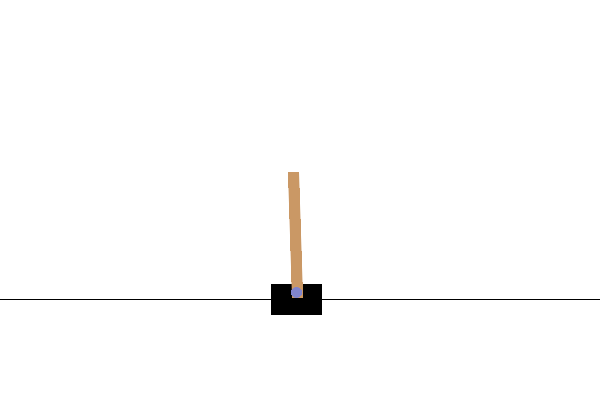

In [125]:
saved_fname2 = play_and_save(Q_network_double, '2', seed=12)
Image(open(saved_fname2,'rb').read())